**Object Detection with Faster RCNN**

In [ ]:
# Common Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import os

In [ ]:
!pip install -U torchvision # We need a new version of torchvision for this project

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import all necessary libraries
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
# We use albumentations as our data augmentation library due to its capability to deal with bounding boxes 
# in multiple formats

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
# Dataset :
# This is our dataset class. It loads all the necessary files and it processes the data so that 
# it can be fed into the model.

In [ ]:
class ObjectDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/AI ML Models/Final_dataset_3classes_objectDetect"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


{0: {'id': 0, 'name': 'pole', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'cross_arm', 'supercategory': 'pole'},
 2: {'id': 2, 'name': 'pole', 'supercategory': 'pole'},
 3: {'id': 3, 'name': 'tag', 'supercategory': 'pole'}}

In [ ]:
# This code just gets a list of classes
classes = [i[1]['name'] for i in categories.items()]
classes 

['pole', 'cross_arm', 'pole', 'tag']

In [ ]:
# Function Calling
train_dataset = ObjectDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


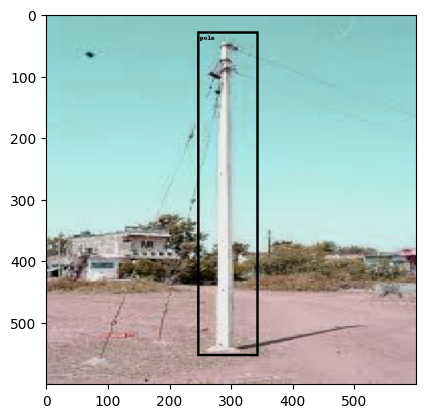

In [ ]:
# This is a sample image and its bounding boxes, this code does not get the model's output
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

45

In [ ]:
# Model
# Our model is FasterRCNN with a backbone of MobileNetV3-Large.  
# This model was trained on 91 classes.
# We need to change the output layers because we, so doing Fine Tuning

In [ ]:
# load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 41.5MB/s]


In [ ]:
# This is our collating function for the train dataloader, it allows us to create batches of data that can be 
# easily pass into the model
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
# The following blocks ensures that the model can take in the data and that it will not crash during training
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
# device = torch.device("cuda") # use GPU to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

In [ ]:
# Training
# The following is a function that will train the model for one epoch. 
# Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically 
# if you pass in the inputs and targets

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
# 10 Epochs should be enough to train this model for a high accuracy
num_epochs=100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 12/12 [01:17<00:00,  6.48s/it]


Epoch 0, lr: 0.010000, loss: 0.253142, loss_classifier: 0.073652, loss_box: 0.165878, loss_rpn_box: 0.009898, loss_object: 0.003715


100%|██████████| 12/12 [01:14<00:00,  6.18s/it]


Epoch 1, lr: 0.010000, loss: 0.337857, loss_classifier: 0.086391, loss_box: 0.235146, loss_rpn_box: 0.012670, loss_object: 0.003650


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


Epoch 2, lr: 0.010000, loss: 0.314389, loss_classifier: 0.083234, loss_box: 0.219160, loss_rpn_box: 0.008333, loss_object: 0.003663


100%|██████████| 12/12 [01:16<00:00,  6.34s/it]


Epoch 3, lr: 0.010000, loss: 0.236561, loss_classifier: 0.068001, loss_box: 0.159244, loss_rpn_box: 0.005810, loss_object: 0.003506


100%|██████████| 12/12 [01:14<00:00,  6.20s/it]


Epoch 4, lr: 0.010000, loss: 0.237627, loss_classifier: 0.069704, loss_box: 0.159736, loss_rpn_box: 0.005237, loss_object: 0.002950


100%|██████████| 12/12 [01:13<00:00,  6.10s/it]


Epoch 5, lr: 0.010000, loss: 0.256248, loss_classifier: 0.071646, loss_box: 0.174672, loss_rpn_box: 0.006162, loss_object: 0.003768


100%|██████████| 12/12 [01:12<00:00,  6.00s/it]


Epoch 6, lr: 0.010000, loss: 0.225887, loss_classifier: 0.056731, loss_box: 0.161212, loss_rpn_box: 0.005325, loss_object: 0.002620


100%|██████████| 12/12 [01:10<00:00,  5.87s/it]


Epoch 7, lr: 0.010000, loss: 0.259267, loss_classifier: 0.073589, loss_box: 0.169248, loss_rpn_box: 0.010575, loss_object: 0.005855


100%|██████████| 12/12 [01:16<00:00,  6.36s/it]


Epoch 8, lr: 0.010000, loss: 0.219538, loss_classifier: 0.059194, loss_box: 0.149319, loss_rpn_box: 0.007213, loss_object: 0.003813


100%|██████████| 12/12 [01:15<00:00,  6.31s/it]


Epoch 9, lr: 0.010000, loss: 0.240142, loss_classifier: 0.063337, loss_box: 0.166015, loss_rpn_box: 0.006635, loss_object: 0.004154


100%|██████████| 12/12 [01:13<00:00,  6.11s/it]


Epoch 10, lr: 0.010000, loss: 0.229969, loss_classifier: 0.065254, loss_box: 0.152929, loss_rpn_box: 0.008148, loss_object: 0.003638


100%|██████████| 12/12 [01:17<00:00,  6.42s/it]


Epoch 11, lr: 0.010000, loss: 0.224519, loss_classifier: 0.056897, loss_box: 0.150856, loss_rpn_box: 0.014030, loss_object: 0.002736


100%|██████████| 12/12 [01:17<00:00,  6.46s/it]


Epoch 12, lr: 0.010000, loss: 0.199321, loss_classifier: 0.050575, loss_box: 0.139313, loss_rpn_box: 0.006207, loss_object: 0.003226


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


Epoch 13, lr: 0.010000, loss: 0.199378, loss_classifier: 0.049474, loss_box: 0.140751, loss_rpn_box: 0.005208, loss_object: 0.003944


100%|██████████| 12/12 [01:08<00:00,  5.71s/it]


Epoch 14, lr: 0.010000, loss: 0.250094, loss_classifier: 0.058409, loss_box: 0.180650, loss_rpn_box: 0.007855, loss_object: 0.003181


100%|██████████| 12/12 [01:12<00:00,  6.02s/it]


Epoch 15, lr: 0.010000, loss: 0.244476, loss_classifier: 0.059634, loss_box: 0.172803, loss_rpn_box: 0.008769, loss_object: 0.003269


100%|██████████| 12/12 [01:12<00:00,  6.05s/it]


Epoch 16, lr: 0.010000, loss: 0.217274, loss_classifier: 0.063807, loss_box: 0.145664, loss_rpn_box: 0.004514, loss_object: 0.003289


100%|██████████| 12/12 [01:11<00:00,  5.93s/it]


Epoch 17, lr: 0.010000, loss: 0.246727, loss_classifier: 0.067493, loss_box: 0.170791, loss_rpn_box: 0.004688, loss_object: 0.003756


100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


Epoch 18, lr: 0.010000, loss: 0.302076, loss_classifier: 0.088752, loss_box: 0.204659, loss_rpn_box: 0.006027, loss_object: 0.002638


100%|██████████| 12/12 [01:13<00:00,  6.15s/it]


Epoch 19, lr: 0.010000, loss: 0.276232, loss_classifier: 0.079965, loss_box: 0.186330, loss_rpn_box: 0.006915, loss_object: 0.003022


100%|██████████| 12/12 [01:11<00:00,  5.98s/it]


Epoch 20, lr: 0.010000, loss: 0.245502, loss_classifier: 0.066648, loss_box: 0.169283, loss_rpn_box: 0.005961, loss_object: 0.003610


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


Epoch 21, lr: 0.010000, loss: 0.235573, loss_classifier: 0.055150, loss_box: 0.170525, loss_rpn_box: 0.006327, loss_object: 0.003571


100%|██████████| 12/12 [01:13<00:00,  6.14s/it]


Epoch 22, lr: 0.010000, loss: 0.344322, loss_classifier: 0.097205, loss_box: 0.236232, loss_rpn_box: 0.007313, loss_object: 0.003571


100%|██████████| 12/12 [01:15<00:00,  6.28s/it]


Epoch 23, lr: 0.010000, loss: 0.291898, loss_classifier: 0.081406, loss_box: 0.200827, loss_rpn_box: 0.005407, loss_object: 0.004258


100%|██████████| 12/12 [01:10<00:00,  5.86s/it]


Epoch 24, lr: 0.010000, loss: 0.317278, loss_classifier: 0.071845, loss_box: 0.235853, loss_rpn_box: 0.005594, loss_object: 0.003986


100%|██████████| 12/12 [01:14<00:00,  6.23s/it]


Epoch 25, lr: 0.010000, loss: 0.321835, loss_classifier: 0.079877, loss_box: 0.226960, loss_rpn_box: 0.010966, loss_object: 0.004033


100%|██████████| 12/12 [01:17<00:00,  6.48s/it]


Epoch 26, lr: 0.010000, loss: 0.248170, loss_classifier: 0.066979, loss_box: 0.170132, loss_rpn_box: 0.006339, loss_object: 0.004720


100%|██████████| 12/12 [01:13<00:00,  6.14s/it]


Epoch 27, lr: 0.010000, loss: 0.224466, loss_classifier: 0.058860, loss_box: 0.155318, loss_rpn_box: 0.006033, loss_object: 0.004254


100%|██████████| 12/12 [01:10<00:00,  5.89s/it]


Epoch 28, lr: 0.010000, loss: 0.219841, loss_classifier: 0.057783, loss_box: 0.154957, loss_rpn_box: 0.004675, loss_object: 0.002426


100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


Epoch 29, lr: 0.010000, loss: 0.286231, loss_classifier: 0.083305, loss_box: 0.193283, loss_rpn_box: 0.007071, loss_object: 0.002572


100%|██████████| 12/12 [01:10<00:00,  5.87s/it]


Epoch 30, lr: 0.010000, loss: 0.328889, loss_classifier: 0.106532, loss_box: 0.209366, loss_rpn_box: 0.007287, loss_object: 0.005704


100%|██████████| 12/12 [01:13<00:00,  6.16s/it]


Epoch 31, lr: 0.010000, loss: 0.287593, loss_classifier: 0.090981, loss_box: 0.186879, loss_rpn_box: 0.005255, loss_object: 0.004478


100%|██████████| 12/12 [01:13<00:00,  6.10s/it]


Epoch 32, lr: 0.010000, loss: 0.286184, loss_classifier: 0.084087, loss_box: 0.189933, loss_rpn_box: 0.008102, loss_object: 0.004062


100%|██████████| 12/12 [01:14<00:00,  6.23s/it]


Epoch 33, lr: 0.010000, loss: 0.272581, loss_classifier: 0.074105, loss_box: 0.187284, loss_rpn_box: 0.007944, loss_object: 0.003248


100%|██████████| 12/12 [01:10<00:00,  5.90s/it]


Epoch 34, lr: 0.010000, loss: 0.274431, loss_classifier: 0.071106, loss_box: 0.193835, loss_rpn_box: 0.006411, loss_object: 0.003078


100%|██████████| 12/12 [01:07<00:00,  5.65s/it]


Epoch 35, lr: 0.010000, loss: 0.312052, loss_classifier: 0.075462, loss_box: 0.228158, loss_rpn_box: 0.005079, loss_object: 0.003352


100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Epoch 36, lr: 0.010000, loss: 0.290682, loss_classifier: 0.064249, loss_box: 0.218068, loss_rpn_box: 0.005823, loss_object: 0.002542


100%|██████████| 12/12 [01:10<00:00,  5.91s/it]


Epoch 37, lr: 0.010000, loss: 0.275150, loss_classifier: 0.063220, loss_box: 0.202822, loss_rpn_box: 0.005785, loss_object: 0.003324


100%|██████████| 12/12 [01:09<00:00,  5.81s/it]


Epoch 38, lr: 0.010000, loss: 0.291337, loss_classifier: 0.060659, loss_box: 0.219985, loss_rpn_box: 0.006740, loss_object: 0.003953


100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


Epoch 39, lr: 0.010000, loss: 0.303035, loss_classifier: 0.078387, loss_box: 0.209095, loss_rpn_box: 0.012638, loss_object: 0.002914


100%|██████████| 12/12 [01:13<00:00,  6.11s/it]


Epoch 40, lr: 0.010000, loss: 0.278679, loss_classifier: 0.071917, loss_box: 0.197386, loss_rpn_box: 0.005374, loss_object: 0.004002


100%|██████████| 12/12 [01:14<00:00,  6.18s/it]


Epoch 41, lr: 0.010000, loss: 0.231328, loss_classifier: 0.057541, loss_box: 0.165669, loss_rpn_box: 0.005024, loss_object: 0.003095


100%|██████████| 12/12 [01:12<00:00,  6.03s/it]


Epoch 42, lr: 0.010000, loss: 0.221730, loss_classifier: 0.070180, loss_box: 0.144185, loss_rpn_box: 0.004682, loss_object: 0.002683


100%|██████████| 12/12 [01:11<00:00,  5.96s/it]


Epoch 43, lr: 0.010000, loss: 0.233769, loss_classifier: 0.060099, loss_box: 0.166632, loss_rpn_box: 0.004024, loss_object: 0.003014


100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


Epoch 44, lr: 0.010000, loss: 0.244363, loss_classifier: 0.066307, loss_box: 0.170871, loss_rpn_box: 0.003859, loss_object: 0.003326


100%|██████████| 12/12 [01:10<00:00,  5.88s/it]


Epoch 45, lr: 0.010000, loss: 0.274869, loss_classifier: 0.065308, loss_box: 0.201645, loss_rpn_box: 0.005528, loss_object: 0.002388


100%|██████████| 12/12 [01:08<00:00,  5.67s/it]


Epoch 46, lr: 0.010000, loss: 0.264136, loss_classifier: 0.062755, loss_box: 0.192968, loss_rpn_box: 0.005866, loss_object: 0.002546


100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


Epoch 47, lr: 0.010000, loss: 0.232342, loss_classifier: 0.062392, loss_box: 0.164528, loss_rpn_box: 0.003347, loss_object: 0.002075


100%|██████████| 12/12 [01:09<00:00,  5.80s/it]


Epoch 48, lr: 0.010000, loss: 0.260797, loss_classifier: 0.061033, loss_box: 0.192936, loss_rpn_box: 0.004053, loss_object: 0.002775


100%|██████████| 12/12 [01:11<00:00,  5.93s/it]


Epoch 49, lr: 0.010000, loss: 0.270059, loss_classifier: 0.060043, loss_box: 0.202591, loss_rpn_box: 0.004322, loss_object: 0.003102


100%|██████████| 12/12 [01:09<00:00,  5.82s/it]


Epoch 50, lr: 0.010000, loss: 0.289027, loss_classifier: 0.066230, loss_box: 0.214856, loss_rpn_box: 0.004810, loss_object: 0.003130


100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


Epoch 51, lr: 0.010000, loss: 0.298329, loss_classifier: 0.074519, loss_box: 0.217336, loss_rpn_box: 0.003997, loss_object: 0.002476


100%|██████████| 12/12 [01:10<00:00,  5.90s/it]


Epoch 52, lr: 0.010000, loss: 0.247703, loss_classifier: 0.067504, loss_box: 0.172671, loss_rpn_box: 0.004559, loss_object: 0.002969


100%|██████████| 12/12 [01:09<00:00,  5.83s/it]


Epoch 53, lr: 0.010000, loss: 0.237479, loss_classifier: 0.057910, loss_box: 0.171964, loss_rpn_box: 0.004290, loss_object: 0.003316


100%|██████████| 12/12 [01:08<00:00,  5.74s/it]


Epoch 54, lr: 0.010000, loss: 0.241570, loss_classifier: 0.066050, loss_box: 0.169028, loss_rpn_box: 0.003490, loss_object: 0.003002


100%|██████████| 12/12 [01:06<00:00,  5.54s/it]


Epoch 55, lr: 0.010000, loss: 0.265862, loss_classifier: 0.067086, loss_box: 0.188984, loss_rpn_box: 0.006958, loss_object: 0.002834


100%|██████████| 12/12 [01:11<00:00,  5.93s/it]


Epoch 56, lr: 0.010000, loss: 0.240410, loss_classifier: 0.065959, loss_box: 0.165711, loss_rpn_box: 0.005933, loss_object: 0.002806


100%|██████████| 12/12 [01:09<00:00,  5.82s/it]


Epoch 57, lr: 0.010000, loss: 0.293961, loss_classifier: 0.089133, loss_box: 0.196871, loss_rpn_box: 0.005431, loss_object: 0.002526


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]


Epoch 58, lr: 0.010000, loss: 0.303032, loss_classifier: 0.111986, loss_box: 0.172822, loss_rpn_box: 0.007248, loss_object: 0.010975


100%|██████████| 12/12 [01:36<00:00,  8.06s/it]


Epoch 59, lr: 0.010000, loss: 0.194591, loss_classifier: 0.061190, loss_box: 0.112379, loss_rpn_box: 0.008185, loss_object: 0.012838


100%|██████████| 12/12 [01:18<00:00,  6.53s/it]


Epoch 60, lr: 0.010000, loss: 0.201372, loss_classifier: 0.064719, loss_box: 0.126645, loss_rpn_box: 0.006230, loss_object: 0.003779


100%|██████████| 12/12 [01:10<00:00,  5.83s/it]


Epoch 61, lr: 0.010000, loss: 0.225066, loss_classifier: 0.068778, loss_box: 0.147980, loss_rpn_box: 0.005078, loss_object: 0.003231


100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Epoch 62, lr: 0.010000, loss: 0.247472, loss_classifier: 0.074907, loss_box: 0.163107, loss_rpn_box: 0.006461, loss_object: 0.002996


100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


Epoch 63, lr: 0.010000, loss: 0.233646, loss_classifier: 0.073257, loss_box: 0.151186, loss_rpn_box: 0.006107, loss_object: 0.003096


100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


Epoch 64, lr: 0.010000, loss: 0.230984, loss_classifier: 0.076432, loss_box: 0.144115, loss_rpn_box: 0.007183, loss_object: 0.003254


100%|██████████| 12/12 [01:09<00:00,  5.83s/it]


Epoch 65, lr: 0.010000, loss: 0.262586, loss_classifier: 0.076280, loss_box: 0.178855, loss_rpn_box: 0.004995, loss_object: 0.002456


100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Epoch 66, lr: 0.010000, loss: 0.250290, loss_classifier: 0.066247, loss_box: 0.175185, loss_rpn_box: 0.006191, loss_object: 0.002666


100%|██████████| 12/12 [01:07<00:00,  5.58s/it]


Epoch 67, lr: 0.010000, loss: 0.256797, loss_classifier: 0.061508, loss_box: 0.188391, loss_rpn_box: 0.003835, loss_object: 0.003063


100%|██████████| 12/12 [01:09<00:00,  5.76s/it]


Epoch 68, lr: 0.010000, loss: 0.275464, loss_classifier: 0.073544, loss_box: 0.194115, loss_rpn_box: 0.005174, loss_object: 0.002631


100%|██████████| 12/12 [01:10<00:00,  5.87s/it]


Epoch 69, lr: 0.010000, loss: 0.215903, loss_classifier: 0.057216, loss_box: 0.150613, loss_rpn_box: 0.005214, loss_object: 0.002861


100%|██████████| 12/12 [01:08<00:00,  5.70s/it]


Epoch 70, lr: 0.010000, loss: 0.240334, loss_classifier: 0.070357, loss_box: 0.161552, loss_rpn_box: 0.004947, loss_object: 0.003477


100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


Epoch 71, lr: 0.010000, loss: 0.223566, loss_classifier: 0.060154, loss_box: 0.157545, loss_rpn_box: 0.003277, loss_object: 0.002590


100%|██████████| 12/12 [01:07<00:00,  5.65s/it]


Epoch 72, lr: 0.010000, loss: 0.235490, loss_classifier: 0.061028, loss_box: 0.169205, loss_rpn_box: 0.002948, loss_object: 0.002308


100%|██████████| 12/12 [01:05<00:00,  5.46s/it]


Epoch 73, lr: 0.010000, loss: 0.277165, loss_classifier: 0.077578, loss_box: 0.191151, loss_rpn_box: 0.005866, loss_object: 0.002570


100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


Epoch 74, lr: 0.010000, loss: 0.267568, loss_classifier: 0.074388, loss_box: 0.186843, loss_rpn_box: 0.004092, loss_object: 0.002245


100%|██████████| 12/12 [01:08<00:00,  5.72s/it]


Epoch 75, lr: 0.010000, loss: 0.235756, loss_classifier: 0.058416, loss_box: 0.170007, loss_rpn_box: 0.004608, loss_object: 0.002725


100%|██████████| 12/12 [01:08<00:00,  5.75s/it]


Epoch 76, lr: 0.010000, loss: 0.246006, loss_classifier: 0.062469, loss_box: 0.175066, loss_rpn_box: 0.005786, loss_object: 0.002686


100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


Epoch 77, lr: 0.010000, loss: 0.236583, loss_classifier: 0.070104, loss_box: 0.159575, loss_rpn_box: 0.004874, loss_object: 0.002030


100%|██████████| 12/12 [01:08<00:00,  5.73s/it]


Epoch 78, lr: 0.010000, loss: 0.254211, loss_classifier: 0.069870, loss_box: 0.177157, loss_rpn_box: 0.004336, loss_object: 0.002848


100%|██████████| 12/12 [01:11<00:00,  5.98s/it]


Epoch 79, lr: 0.010000, loss: 0.225271, loss_classifier: 0.058949, loss_box: 0.156825, loss_rpn_box: 0.006727, loss_object: 0.002770


100%|██████████| 12/12 [01:08<00:00,  5.72s/it]


Epoch 80, lr: 0.010000, loss: 0.197364, loss_classifier: 0.053801, loss_box: 0.131374, loss_rpn_box: 0.009848, loss_object: 0.002342


100%|██████████| 12/12 [01:09<00:00,  5.80s/it]


Epoch 81, lr: 0.010000, loss: 0.201751, loss_classifier: 0.055362, loss_box: 0.137430, loss_rpn_box: 0.006222, loss_object: 0.002737


100%|██████████| 12/12 [01:11<00:00,  5.92s/it]


Epoch 82, lr: 0.010000, loss: 0.210966, loss_classifier: 0.053270, loss_box: 0.145593, loss_rpn_box: 0.009684, loss_object: 0.002419


100%|██████████| 12/12 [01:14<00:00,  6.17s/it]


Epoch 83, lr: 0.010000, loss: 0.191974, loss_classifier: 0.049862, loss_box: 0.135416, loss_rpn_box: 0.004070, loss_object: 0.002626


100%|██████████| 12/12 [01:09<00:00,  5.81s/it]


Epoch 84, lr: 0.010000, loss: 0.194903, loss_classifier: 0.056969, loss_box: 0.132278, loss_rpn_box: 0.002856, loss_object: 0.002800


100%|██████████| 12/12 [01:06<00:00,  5.55s/it]


Epoch 85, lr: 0.010000, loss: 0.205191, loss_classifier: 0.047500, loss_box: 0.152474, loss_rpn_box: 0.002995, loss_object: 0.002222


100%|██████████| 12/12 [01:06<00:00,  5.55s/it]


Epoch 86, lr: 0.010000, loss: 0.207748, loss_classifier: 0.055543, loss_box: 0.146748, loss_rpn_box: 0.003014, loss_object: 0.002443


100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


Epoch 87, lr: 0.010000, loss: 0.192182, loss_classifier: 0.050051, loss_box: 0.136820, loss_rpn_box: 0.002908, loss_object: 0.002402


100%|██████████| 12/12 [01:06<00:00,  5.54s/it]


Epoch 88, lr: 0.010000, loss: 0.245706, loss_classifier: 0.061709, loss_box: 0.179470, loss_rpn_box: 0.002658, loss_object: 0.001869


100%|██████████| 12/12 [01:04<00:00,  5.36s/it]


Epoch 89, lr: 0.010000, loss: 0.300474, loss_classifier: 0.068540, loss_box: 0.225793, loss_rpn_box: 0.003942, loss_object: 0.002198


100%|██████████| 12/12 [01:07<00:00,  5.59s/it]


Epoch 90, lr: 0.010000, loss: 0.288602, loss_classifier: 0.089078, loss_box: 0.193338, loss_rpn_box: 0.003952, loss_object: 0.002234


100%|██████████| 12/12 [01:08<00:00,  5.68s/it]


Epoch 91, lr: 0.010000, loss: 0.251281, loss_classifier: 0.076067, loss_box: 0.167440, loss_rpn_box: 0.003837, loss_object: 0.003937


100%|██████████| 12/12 [01:03<00:00,  5.32s/it]


Epoch 92, lr: 0.010000, loss: 0.236646, loss_classifier: 0.061921, loss_box: 0.164191, loss_rpn_box: 0.004368, loss_object: 0.006165


100%|██████████| 12/12 [01:12<00:00,  6.01s/it]


Epoch 93, lr: 0.010000, loss: 0.232466, loss_classifier: 0.061237, loss_box: 0.164803, loss_rpn_box: 0.003898, loss_object: 0.002528


100%|██████████| 12/12 [01:07<00:00,  5.61s/it]


Epoch 94, lr: 0.010000, loss: 0.208744, loss_classifier: 0.063996, loss_box: 0.138156, loss_rpn_box: 0.003709, loss_object: 0.002883


100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


Epoch 95, lr: 0.010000, loss: 0.204036, loss_classifier: 0.065670, loss_box: 0.132124, loss_rpn_box: 0.003285, loss_object: 0.002956


100%|██████████| 12/12 [01:05<00:00,  5.49s/it]


Epoch 96, lr: 0.010000, loss: 0.198531, loss_classifier: 0.058757, loss_box: 0.133614, loss_rpn_box: 0.003812, loss_object: 0.002349


100%|██████████| 12/12 [01:04<00:00,  5.36s/it]


Epoch 97, lr: 0.010000, loss: 0.247683, loss_classifier: 0.074480, loss_box: 0.166963, loss_rpn_box: 0.004328, loss_object: 0.001911


100%|██████████| 12/12 [01:06<00:00,  5.51s/it]


Epoch 98, lr: 0.010000, loss: 0.212744, loss_classifier: 0.062602, loss_box: 0.143320, loss_rpn_box: 0.004999, loss_object: 0.001823


100%|██████████| 12/12 [01:07<00:00,  5.60s/it]

Epoch 99, lr: 0.010000, loss: 0.257049, loss_classifier: 0.065007, loss_box: 0.182344, loss_rpn_box: 0.005548, loss_object: 0.004149


In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
# Evaluation
test_dataset = ObjectDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[3]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

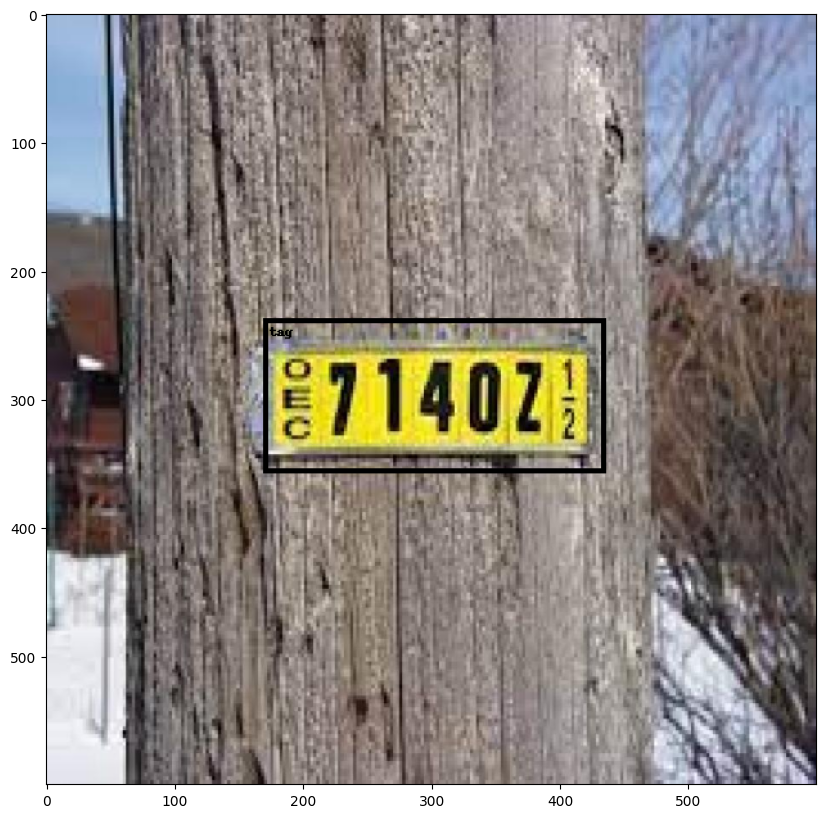

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[7]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

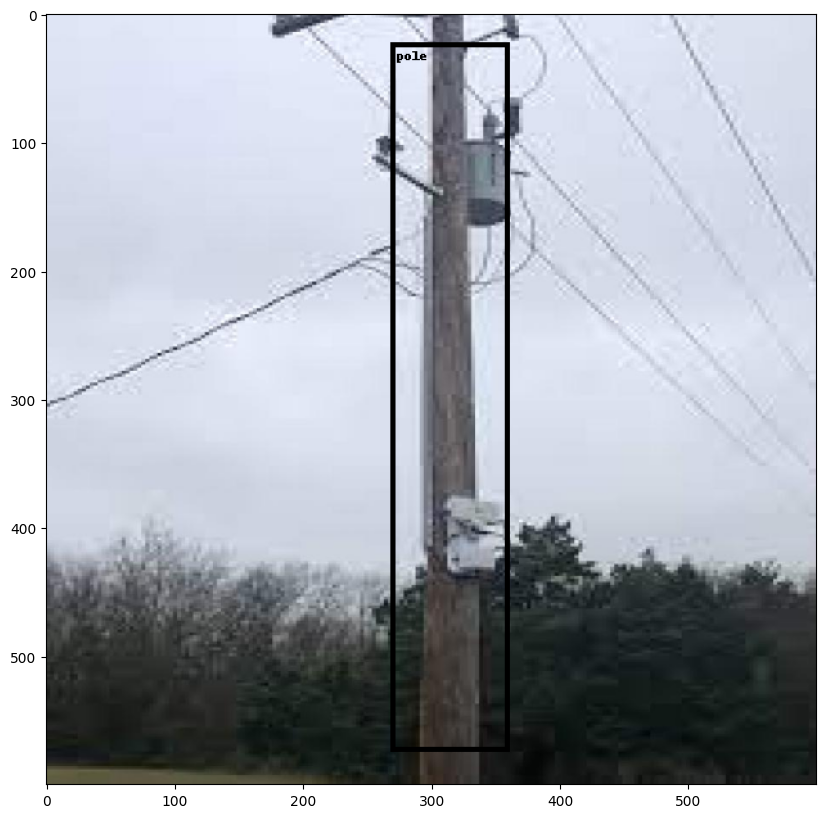

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

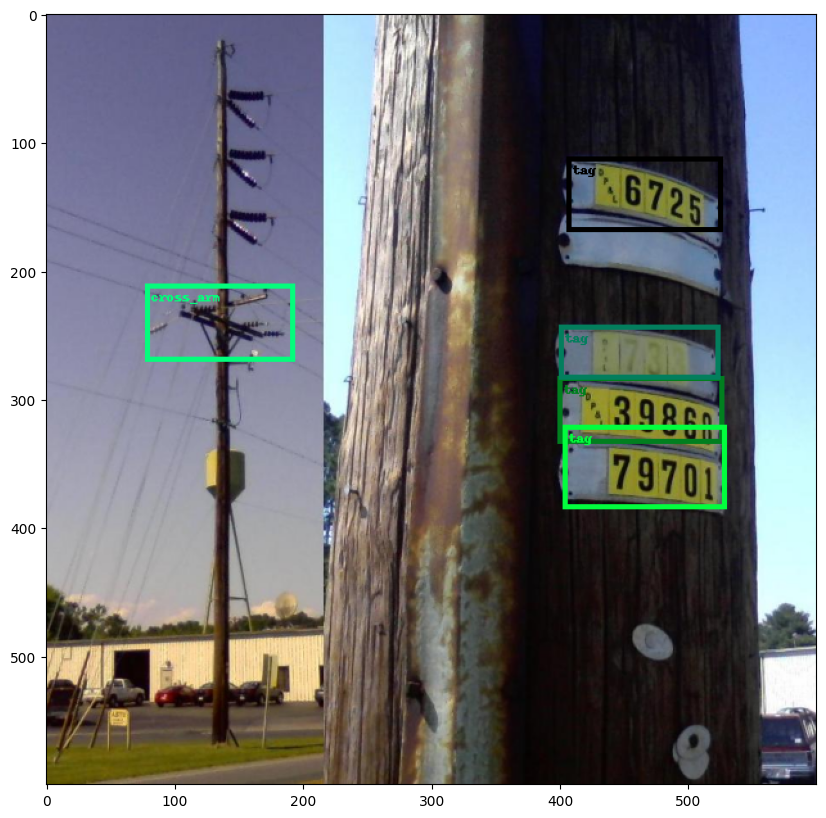

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[1]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

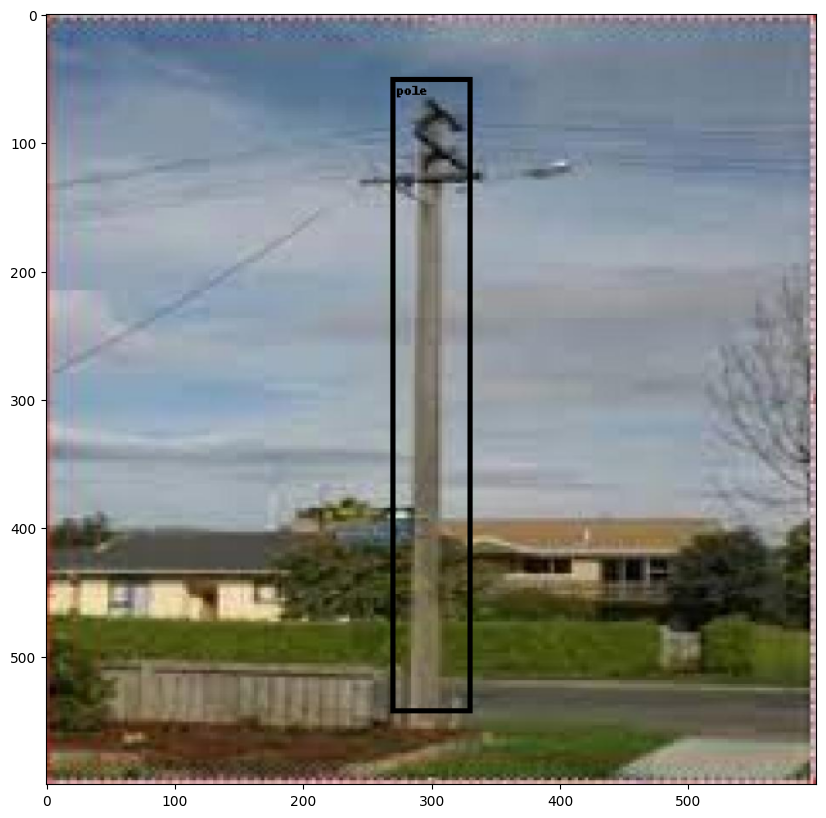

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[4]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

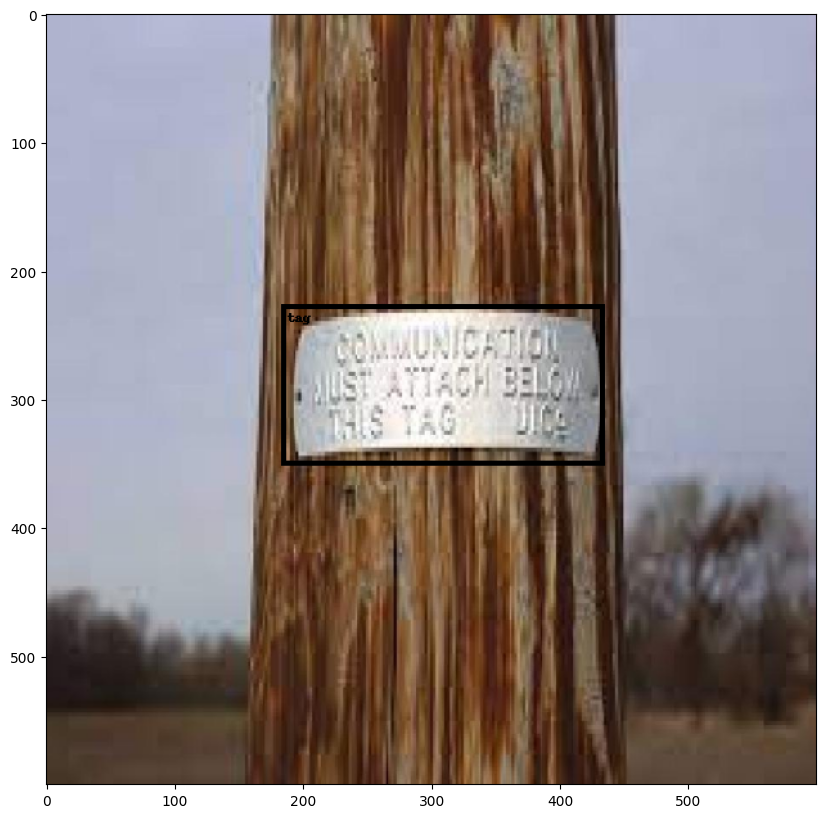

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[6]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

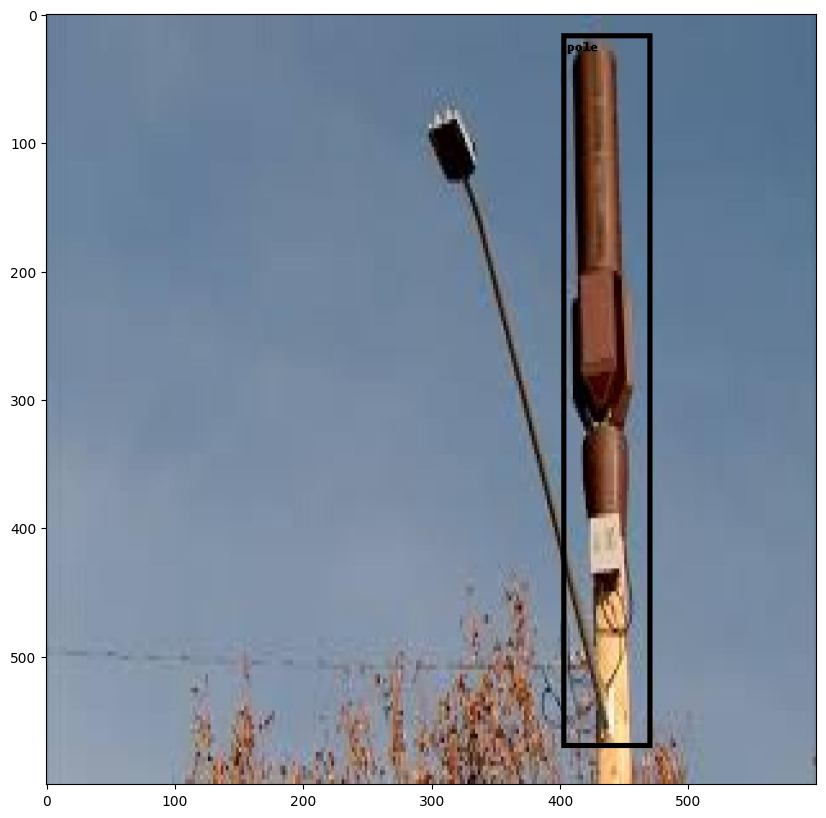

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[9]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

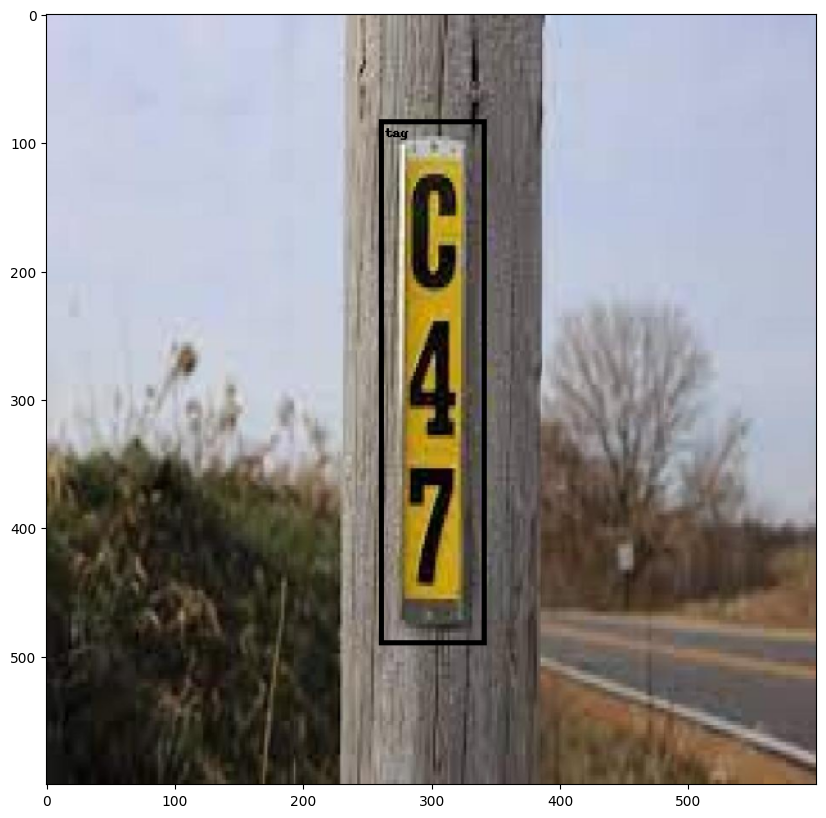

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[10]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

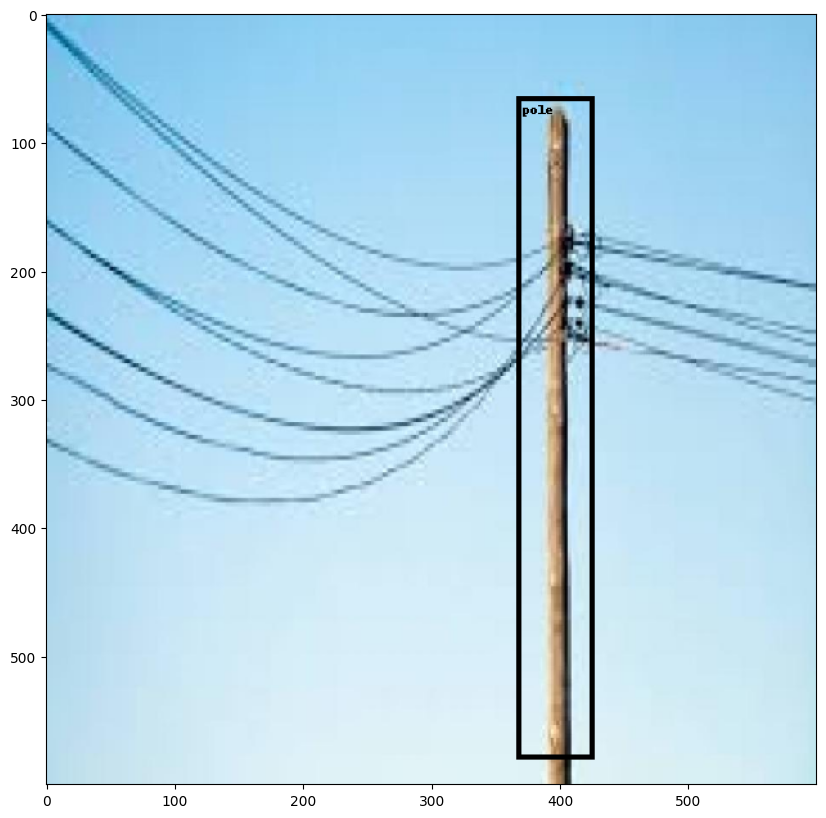

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
img, _ = test_dataset[11]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

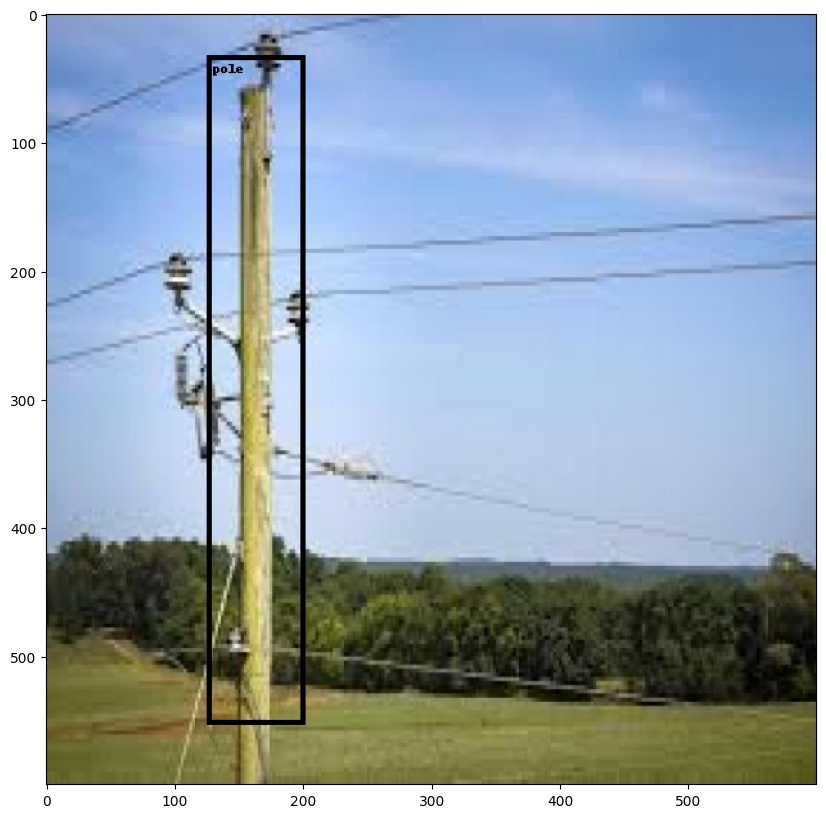

In [ ]:
# it did learn
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

### Save the model

In [ ]:
# # save the model (50epochs)
# # Assume `model` is the FRCNN model that you want to save
# # Save the model to a file
# import torch
# torch.save(model.state_dict(), "FRCNN_MODEL_3Classes.pth")

In [ ]:
# save the model (100epochs)
# Assume `model` is the FRCNN model that you want to save
# Save the model to a file
import torch
torch.save(model.state_dict(), "FRCNN_MODEL_3Classes_100Epochs.pth")

In [ ]:
# Used Roboflow for mAP : got 0.91 mPA (performance metric of Object Detection Models)

### Train dataset


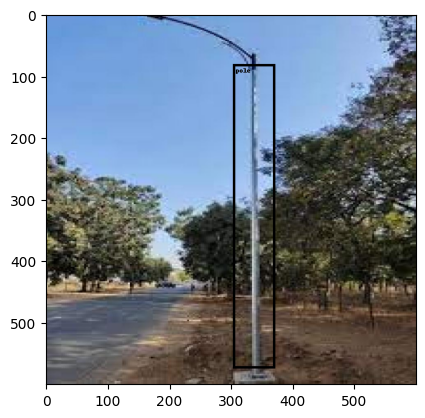

In [ ]:
# This is a sample image and its bounding boxes, this code does not get the model's output
# Lets view a sample
sample = train_dataset[10]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

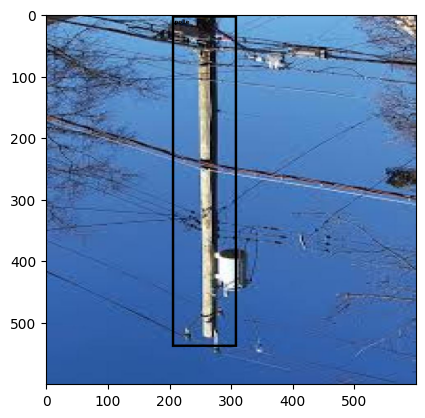

In [ ]:
# This is a sample image and its bounding boxes, this code does not get the model's output
# Lets view a sample
sample = train_dataset[23]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

# Prediction Script - User Test function:

In [ ]:
# import libraries
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
#from torchvision.models.detection import fasterrcnn_resnet50_fpn
import os
import pandas as pd
import numpy as np
import cv2

# load the faster rcnn model
modeltest = models.detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=4)
in_features = modeltest.roi_heads.box_predictor.cls_score.in_features # we need to change the head
modeltest.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

# Load the saved parameters into the model
modeltest.load_state_dict(torch.load("FRCNN_MODEL_3Classes_100Epochs.pth"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modeltest.to(device)

# Number of classes
classes = ['pole', 'cross_arm', 'pole', 'tag']

In [ ]:
# define the function to perform object detection on an image
def detect_objects(image_path):
    # load the image
    image = Image.open(image_path).convert('RGB')
    
    # convert the image to a tensor
    image_tensor = ToTensor()(image).to(device)
    
    # run the image through the model to get the predictions
    modeltest.eval()
    with torch.no_grad():
        predictions = modeltest([image_tensor])

    # filter out the predictions below the threshold
    threshold = 0.5
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    mask = scores > threshold
    scores = scores[mask]
    boxes = boxes[mask]
    labels = labels[mask]

    # create a new image with the predicted objects outlined in rectangles
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        
        # draw the rectangle around the object
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
        
        # write the object class above the rectangle
        class_name = classes[label]
        draw.text((box[0], box[1]), class_name, fill='yellow')
    
    # show the image
    image.show()

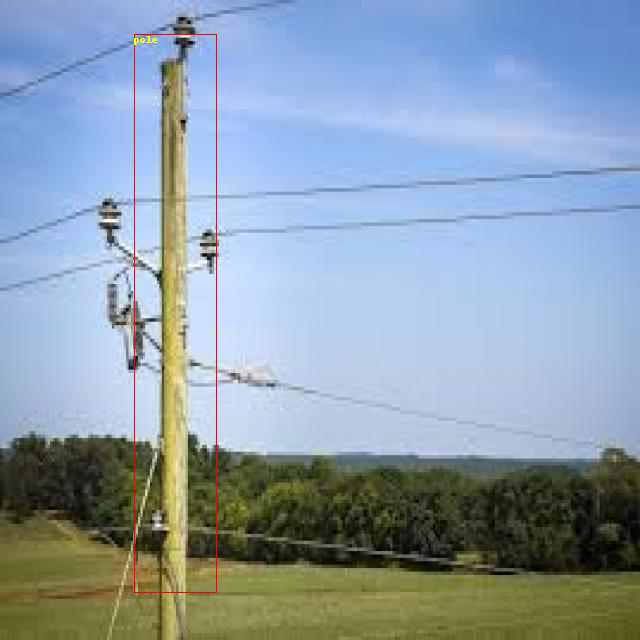

In [ ]:
img = '/content/pol5_jpg.rf.bc8420e5ac46bbed424c1ab28ff0bec4.jpg'
detect_objects(img)

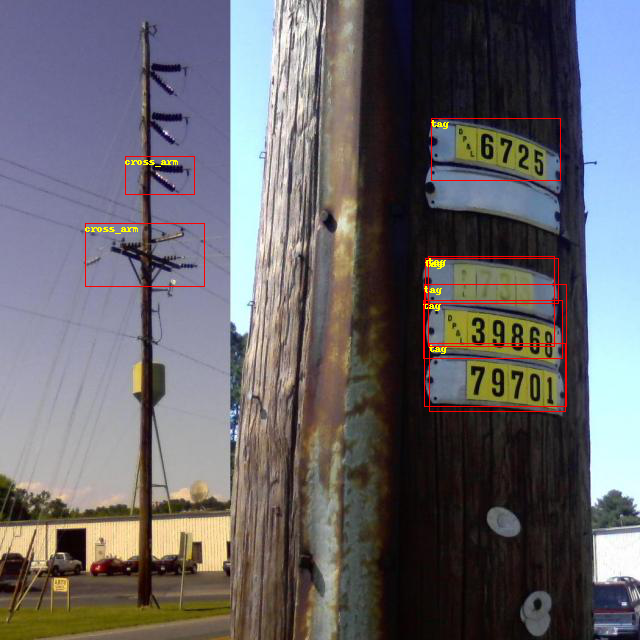

In [ ]:
img1 = '/content/tag4_jpg.rf.46ec610223ca1e1fc771186670a75286.jpg'
detect_objects(img1)

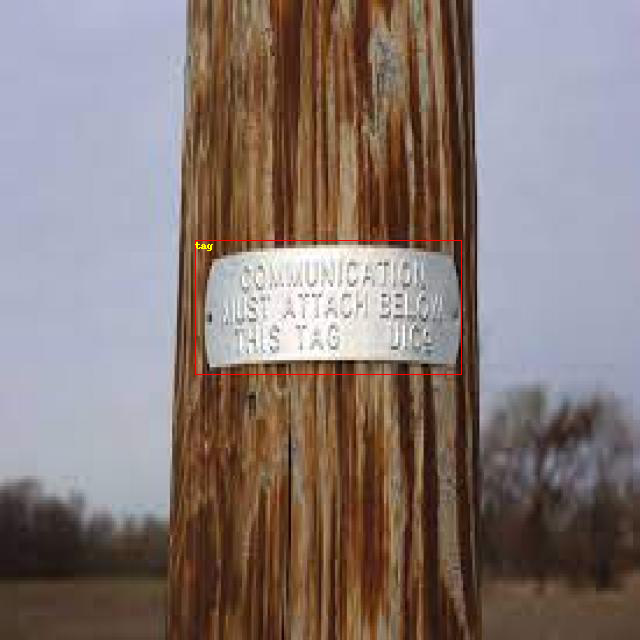

In [ ]:
img2 = '/content/tag8_jpg.rf.0309b7dfc6bddc97e472463027d6b3c6.jpg'
detect_objects(img2)